In [1]:
# Defining important packages upfront
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
import math
import statsmodels.api as sm
from IPython.display import Latex
from IPython.display import Math

# Reading in the data file:
df=pd.read_stata('PS3_data.dta')

# Defining a new variable for wage rate:
df['wage_rate']=df['hlabinc']/df['hannhrs']

In [2]:
# Creating dummy variables for Black, Hispanic and Other Race:

def black(row):
    """
    Function that rakes in the dataframe as input and creates a coded value (val) based on the conditions
    
    """
    if row['hrace']==2:
        val=1
    elif pd.isnull(row['hrace']):
        val=row['hrace']
    else:
        val=0
    return val

def hispanic(row):
    """
    Function that rakes in the dataframe as input and creates a coded value (val) based on the conditions
    
    """
    if row['hrace']==5:
        val=1
    elif pd.isnull(row['hrace']):
        val=row['hrace']
    else:
        val=0
    return val

def otherrace(row):
    """
    Function that rakes in the dataframe as input and creates a coded value (val) based on the conditions
    
    """
    if (row['hrace']==1 or row['hrace']==2 or row['hrace']==5):
        val=0
    elif pd.isnull(row['hrace']):
        val=row['hrace']
    else:
        val=1
    return val

In [3]:
# Calling in the functions defined above to create the encoded race variables:
df['Black']=df.apply(black,axis=1)
df['Hispanic']=df.apply(hispanic,axis=1)
df['OtherRace']=df.apply(otherrace,axis=1)

In [4]:
# Some of the values in 'hrace' are NaN's and should not be coded as 0's. Checking if the new variables has preserved NaNs
df.Hispanic.unique()

array([  0.,  nan])

# From the above it can be seen that there are no Hispanics in the dataset, hence this factor will not be included in the analysis otherwise it will cause multicollinearity

In [5]:
# Data Preparation: Creating 4 different datasets for years 1971, 1980, 1990, 2000 
# Criteria used is male heads, aged 25 to 60 and hourly wage rate of greater than $7
df_1971=df[(df.year==1971) & (df.hsex==1) & (df.age>=25) & (df.age<=60) & (df.wage_rate>=7)]
df_1980=df[(df.year==1980) & (df.hsex==1) & (df.age>=25) & (df.age<=60) & (df.wage_rate>=7)]
df_1990=df[(df.year==1990) & (df.hsex==1) & (df.age>=25) & (df.age<=60) & (df.wage_rate>=7)]
df_2000=df[(df.year==2000) & (df.hsex==1) & (df.age>=25) & (df.age<=60) & (df.wage_rate>=7)]


# Selecting only the variables required for the MLE estimation and OLS regression. They are:

1. hlabinc: annual labor income of the head
2. hannhrs: annual hours of the head
3. hsex: gender of the head
4. age: age of the head
5. hyrsed: years of education of the head
6. Black: whether the head is black or not
7. Hispanic: whether the head is hispanic or not
8. OtherRace: whether the head is any race other than black and hispanic

In [6]:
# Datasets for 1971, 1980, 1990 and 2000 with the above variables only and data points with missing values removed:
df1_1971=df_1971[['hlabinc','hannhrs','hsex','age','hyrsed','Black','Hispanic','OtherRace']].dropna()
df1_1980=df_1980[['hlabinc','hannhrs','hsex','age','hyrsed','Black','Hispanic','OtherRace']].dropna()
df1_1990=df_1990[['hlabinc','hannhrs','hsex','age','hyrsed','Black','Hispanic','OtherRace']].dropna()
df1_2000=df_2000[['hlabinc','hannhrs','hsex','age','hyrsed','Black','Hispanic','OtherRace']].dropna()


# Exploratory data analysis

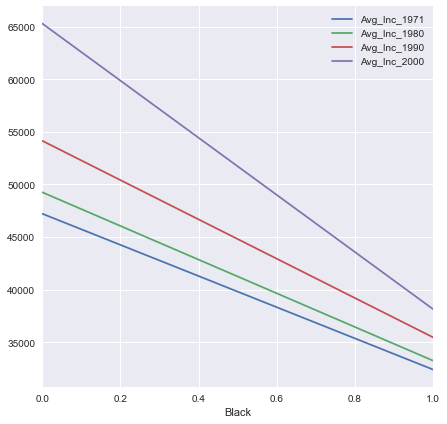

In [7]:
# Exploratory data analysis for informing the initial parameter estimates:

# First, trying to get an idea of the income for black vs. non black

# Finding mean incomes across the years for blacks vs. non blacks
income_black_1971=pd.DataFrame(df1_1971.groupby(['Black'])['hlabinc'].mean())
income_black_1971.reset_index(level=0,inplace=True)

income_black_1980=pd.DataFrame(df1_1980.groupby(['Black'])['hlabinc'].mean())
income_black_1980.reset_index(level=0,inplace=True)

income_black_1990=pd.DataFrame(df1_1990.groupby(['Black'])['hlabinc'].mean())
income_black_1990.reset_index(level=0,inplace=True)

income_black_2000=pd.DataFrame(df1_2000.groupby(['Black'])['hlabinc'].mean())
income_black_2000.reset_index(level=0,inplace=True)

# Merge the average income data into one dataframe
income_black=[income_black_1971,income_black_1980,income_black_1990,income_black_2000]
income_black1=df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Black'],how='outer'), income_black)
income_black1.columns=['Black','Avg_Inc_1971','Avg_Inc_1980','Avg_Inc_1990','Avg_Inc_2000']
income_black1.plot(x='Black',y=['Avg_Inc_1971','Avg_Inc_1980','Avg_Inc_1990','Avg_Inc_2000'],grid=True, figsize=(7,7))
plt.show()
# Roughly, the average incomes for black is less by ~ $15k

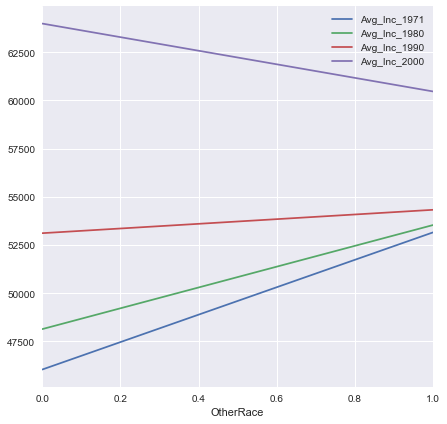

In [8]:
# Exploratory data analysis for informing the initial parameter estimates:

# First, trying to get an idea of the income for Other Race 

# First creating mean incomes by black vs. non black for all four years
income_or_1971=pd.DataFrame(df1_1971.groupby(['OtherRace'])['hlabinc'].mean())
income_or_1971.reset_index(level=0,inplace=True)

income_or_1980=pd.DataFrame(df1_1980.groupby(['OtherRace'])['hlabinc'].mean())
income_or_1980.reset_index(level=0,inplace=True)

income_or_1990=pd.DataFrame(df1_1990.groupby(['OtherRace'])['hlabinc'].mean())
income_or_1990.reset_index(level=0,inplace=True)

income_or_2000=pd.DataFrame(df1_2000.groupby(['OtherRace'])['hlabinc'].mean())
income_or_2000.reset_index(level=0,inplace=True)

# Merge the average income data into one dataframe
income_or=[income_or_1971,income_or_1980,income_or_1990,income_or_2000]
income_or1=reduce(lambda  left,right: pd.merge(left,right,on=['OtherRace'],how='outer'), income_or)
income_or1.columns=['OtherRace','Avg_Inc_1971','Avg_Inc_1980','Avg_Inc_1990','Avg_Inc_2000']
income_or1.plot(x='OtherRace',y=['Avg_Inc_1971','Avg_Inc_1980','Avg_Inc_1990','Avg_Inc_2000'],grid=True, figsize=(7,7))
plt.show()

# Roughly, the average incomes for OtherRace is more by ~ $5 to $7k for 1971 and 1980. But in the year 2000 is actuall less
# Therefore, for the year 1971, I will use an initial guess of 7000 for OtherRace

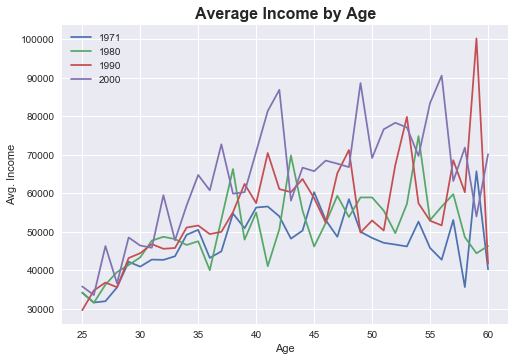

In [9]:
## Now lets look at the correlation plot with the correlation between income and age:


## Second, understanding the differences in average incomes by age

# Creating mean income database for each age (=25 to 60)
income_age_1971=pd.DataFrame(df1_1971.groupby(['age'])['hlabinc'].mean())
income_age_1971.reset_index(level=0,inplace=True)

income_age_1980=pd.DataFrame(df1_1980.groupby(['age'])['hlabinc'].mean())
income_age_1980.reset_index(level=0,inplace=True)

income_age_1990=pd.DataFrame(df1_1990.groupby(['age'])['hlabinc'].mean())
income_age_1990.reset_index(level=0,inplace=True)

income_age_2000=pd.DataFrame(df1_2000.groupby(['age'])['hlabinc'].mean())
income_age_2000.reset_index(level=0,inplace=True)

# Merge the average income data into one dataframe
income_age=[income_age_1971,income_age_1980,income_age_1990,income_age_2000]
income_age1=reduce(lambda  left,right: pd.merge(left,right,on=['age'],how='outer'), income_age)
income_age1.columns=['Age','Avg_Inc_1971','Avg_Inc_1980','Avg_Inc_1990','Avg_Inc_2000']

# Actual plotting
plt.plot(income_age1['Age'],income_age1['Avg_Inc_1971'],label="1971")
plt.plot(income_age1['Age'],income_age1['Avg_Inc_1980'],label="1980")
plt.plot(income_age1['Age'],income_age1['Avg_Inc_1990'],label="1990")
plt.plot(income_age1['Age'],income_age1['Avg_Inc_2000'],label="2000")
plt.legend(loc="upper left")
plt.xlabel('Age')
plt.ylabel('Avg. Income')
plt.title("Average Income by Age", fontsize=16, fontweight='bold')
plt.show()
# Roughly, the income increases by ~ $15k every 5 years. Hence, the yearly increment is ~ $ 3k

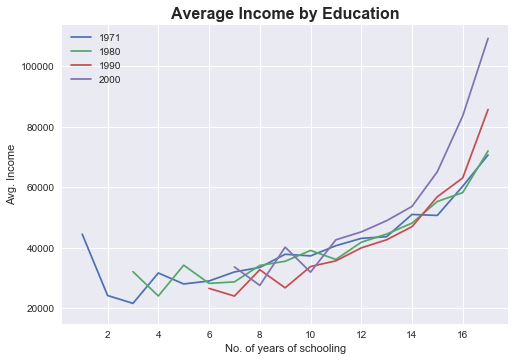

In [10]:
## Now lets look at relationship between income and education:


## Second, understanding the differences in average incomes by age

# Creating mean income database for each age (=25 to 60)
income_edu_1971=pd.DataFrame(df1_1971.groupby(['hyrsed'])['hlabinc'].mean())
income_edu_1971.reset_index(level=0,inplace=True)

income_edu_1980=pd.DataFrame(df1_1980.groupby(['hyrsed'])['hlabinc'].mean())
income_edu_1980.reset_index(level=0,inplace=True)

income_edu_1990=pd.DataFrame(df1_1990.groupby(['hyrsed'])['hlabinc'].mean())
income_edu_1990.reset_index(level=0,inplace=True)

income_edu_2000=pd.DataFrame(df1_2000.groupby(['hyrsed'])['hlabinc'].mean())
income_edu_2000.reset_index(level=0,inplace=True)

# Merge the average income data into one dataframe
income_edu=[income_edu_1971,income_edu_1980,income_edu_1990,income_edu_2000]
income_edu1=reduce(lambda  left,right: pd.merge(left,right,on=['hyrsed'],how='outer'), income_edu)
income_edu1.columns=['Edu','Avg_Inc_1971','Avg_Inc_1980','Avg_Inc_1990','Avg_Inc_2000']

# Actual plotting
plt.plot(income_edu1['Edu'],income_edu1['Avg_Inc_1971'],label="1971")
plt.plot(income_edu1['Edu'],income_edu1['Avg_Inc_1980'],label="1980")
plt.plot(income_edu1['Edu'],income_edu1['Avg_Inc_1990'],label="1990")
plt.plot(income_edu1['Edu'],income_edu1['Avg_Inc_2000'],label="2000")
plt.legend(loc="upper left")
plt.xlabel('No. of years of schooling')
plt.ylabel('Avg. Income')
plt.title("Average Income by Education", fontsize=16, fontweight='bold')
plt.show()
# Roughly, the income increases by ~ $2k every 2 years. Hence, the yearly increment is ~ $ 1k

## Log -likelihood function for simple linear regression:

Linear regression with y as the output and x as the explnatory variable(s) can be represented as:

$$ y=x'\beta + \epsilon $$

where:

$$ \epsilon \sim N(0,\sigma^2) $$

$$ x \in R^{mxn}$$

$$ y \in R^n $$

$$ \beta \in R^m $$ 

Given the normally distributed error term, it can be seen that:

$$ y \sim N(x'\beta, \sigma^2) $$

Therefore, the likelihood of observing output y, given the data x and parameter $ \sigma $ can be expressed as:

$$ f(y | x,\sigma)= \frac{1}{\sqrt[]{(2\pi)^n}\sigma} \exp(\frac{-1}{2\sigma^2}(y - x'\beta)^T(y - x'\beta)) $$

This is known as the likelihood function $ L(y|x,\sigma) $.

Typicallly, for easier estimation, we take the natural logarithm of this function, which is the log-likelihood function:

$$ \log(L(y|x,\sigma))= -\frac{1}{2}n\log(2\pi) - n\log(\sigma)  - \frac{1}{2\sigma^2}(y - x'\beta)^T(y - x'\beta) $$


The maximum likelihood estimation relies on finding the set of parameters $\beta $ that maximizes log-likelihood function,. Hence, it can be expressed as :

$$ \min_{\beta}\ [\frac{1}{2\sigma^2}\sum_{i=1}^{i=n}(y_{i} - x_{i}'\beta)^2] + k$$

where:

$$ k= \frac{1}{2}n [\log(2\pi) + \log(\sigma^2)] $$

# Defining the MLE optimization function:

In [11]:
# Define the likelihood function:
def MLERegression(params,data):
    
    """
    
    The MLE routine takes in an array of initial parameter guesses and the dataset (which has ouput and inputs)
    
    The parameter guesses are then assigned to the intercept and coefficient estimates below(intercept and beta_)
    """
    intercept,beta_edu, beta_age, beta_black, beta_other= params[0], params[1], params[2], params[3], params[4]
    
    # The predicted values based on the intercept, coefficient guesses and the actual data variables are:
    
    yhat = intercept + beta_edu * data['hyrsed'] + beta_age * data['age']  + beta_black *data['Black'] + beta_other * data['OtherRace']
    

    # Defining some parameters required for the MLE estimation
    
    '''
    y is the observed ouput from the data (income of the houselhold head)
    n is the total number of observations
    sd is the standard deviation of the normal distribution. 
    From the derivation, sigma is the std. deviation of actual - predicted values
    
    '''
    y = data['hlabinc']
    n = len(data.index)
    sd = (y - yhat).std()
    
    '''
    Several versions of the log likelihood function can be used. I will use the one derived above. 
    But the others rely more on python attributes to come to derive the objective function. 
    They all yield the same results
    
    '''
    #negLL=-np.sum(stats.norm.logpdf(y,loc=yhat,scale=sd))
    
    #negLL=-np.sum(np.log(stats.norm.pdf(y,yhat,sd)))
    
    k = 0.5 * (n * np.log(2 * 3.14)) + n * np.log(sd * sd)
    
    negLL = 0.5 * (1 / (sd * sd))*(np.sum((y - yhat) * (y - yhat))) + k
    
    return(negLL)

# Estimating MLE Ceofficients

In [12]:
# Calling in the MLE optimiaztion routine on all four datasets and storing the results

# List of dataframes for four years to be supplied to the MLE optimization routine:
df_list=[df1_1971,df1_1980,df1_1990,df1_2000]

# Initializing a dataframe that will store all the coefficients
df_MLE_Coeff=pd.DataFrame()

for df_loop in df_list:
    
    # Define the data set used for the regressions right here, so that it does not need to be changed everywhere for different years:
    df_reg=df_loop

    # Initial guess for the coefficients are based on the exploratory data analysis
    guess_beta=np.array([1000,3000,-15000, 7000])
        
    # Using the initial betas and the actual observed output (y), I calculate the intercept array
    intercept= df_reg['hlabinc'] - np.dot(df_reg[['hyrsed','age','Black', 'OtherRace']],guess_beta) 
    
    # The mean of the intercept across all data points is considered to be the initial intercept guess
    guess_intercept=intercept.mean()

    # Putting together an array consisting of the initial intercept and parameter values
    guess=np.array([guess_intercept, guess_beta[0], guess_beta[1], guess_beta[2], guess_beta[3]]) 
    
    # Calling in the optimization routine. The dataset for a particular year is to be provided
    results=minimize(MLERegression, guess,method='Nelder-Mead',
                 args=(df_reg[['hlabinc','hyrsed','age','Black','OtherRace']]),
                 options={'disp':False,'maxiter':5000})
    
    # The coefficient estimates from the MLE estimation are:

    Coefficients_MLE=pd.DataFrame(np.round(results.x,2),['const','hyrsed','age','Black','OtherRace'])
    Coefficients_MLE.reset_index(level=0,inplace=True)
    Coefficients_MLE.columns=['Variables','Coeff_MLE']
    df_MLE_Coeff=pd.concat([df_MLE_Coeff, Coefficients_MLE],axis=1)  

# Changing column names for the respective years
df_MLE_Coeff.columns.values[1]='Coeff_MLE_1971'
df_MLE_Coeff.columns.values[3]='Coeff_MLE_1980'
df_MLE_Coeff.columns.values[5]='Coeff_MLE_1990'
df_MLE_Coeff.columns.values[7]='Coeff_MLE_2000'
df_MLE_Coeff=df_MLE_Coeff.loc[:, ~df_MLE_Coeff.columns.duplicated()]
    

# MLE Coefficients

In [13]:
df_MLE_Coeff

,Variables,Coeff_MLE_1971,Coeff_MLE_1980,Coeff_MLE_1990,Coeff_MLE_2000
0,const,-29316.88,-38264.16,-77113.15,-103101.89
1,hyrsed,3855.52,4363.24,7012.02,9762.02
2,age,712.03,763.87,858.25,783.72
3,Black,-7178.68,-8882.87,-10587.52,-18322.72
4,OtherRace,10218.47,5190.09,-1263.78,-2739.14


# Estimating the OLS coefficients

In [14]:
# Estimating the OLS Coefficients for the four years as well:

# List of dataframes for four years to be supplied to the MLE optimization routine:
df_list=[df1_1971,df1_1980,df1_1990,df1_2000]

# Initializing a dataframe that will store all the coefficients
df_OLS_Coeff=pd.DataFrame()

for df_loop in df_list:
    
    # Define the data set used for the regressions right here, so that it does not need to be changed everywhere for different years:
    df_reg=df_loop
    
    reg1=sm.OLS(endog=df_reg['hlabinc'],exog=sm.add_constant(df_reg[['hyrsed', 'age', 'Black','OtherRace']]))
    results_OLS=reg1.fit()
    #results_OLS.summary()
    Coefficients_OLS=pd.DataFrame(np.round(results_OLS.params,2))
    Coefficients_OLS.reset_index(level=0,inplace=True)
    Coefficients_OLS.columns=['Variables','Coeff_OLS']
    df_OLS_Coeff=pd.concat([df_OLS_Coeff, Coefficients_OLS],axis=1)  

# Changing column names for the respective years
df_OLS_Coeff.columns.values[1]='Coeff_OLS_1971'
df_OLS_Coeff.columns.values[3]='Coeff_OLS_1980'
df_OLS_Coeff.columns.values[5]='Coeff_OLS_1990'
df_OLS_Coeff.columns.values[7]='Coeff_OLS_2000'
df_OLS_Coeff=df_OLS_Coeff.loc[:, ~df_OLS_Coeff.columns.duplicated()]
    


# OLS Coefficients

In [15]:
df_OLS_Coeff

,Variables,Coeff_OLS_1971,Coeff_OLS_1980,Coeff_OLS_1990,Coeff_OLS_2000
0,const,-29315.79,-38257.30,-77113.09,-103112.94
1,hyrsed,3855.47,4363.40,7012.21,9763.24
2,age,712.02,763.68,858.17,783.49
3,Black,-7174.96,-8888.72,-10591.52,-18310.82
4,OtherRace,10221.15,5190.20,-1264.23,-2750.54


# Side-by-Side Comparison of MLE and OLS coefficients

In [16]:
MLE_OLS_Comparison=pd.concat([df_MLE_Coeff['Variables'],df_MLE_Coeff['Coeff_MLE_1971'],df_OLS_Coeff['Coeff_OLS_1971']
                               ,df_MLE_Coeff['Coeff_MLE_1980'],df_OLS_Coeff['Coeff_OLS_1980']
                               ,df_MLE_Coeff['Coeff_MLE_1990'],df_OLS_Coeff['Coeff_OLS_1990']
                               ,df_MLE_Coeff['Coeff_MLE_2000'],df_OLS_Coeff['Coeff_OLS_2000']],axis=1)

In [17]:
MLE_OLS_Comparison

,Variables,Coeff_MLE_1971,Coeff_OLS_1971,Coeff_MLE_1980,Coeff_OLS_1980,Coeff_MLE_1990,Coeff_OLS_1990,Coeff_MLE_2000,Coeff_OLS_2000
0,const,-29316.88,-29315.79,-38264.16,-38257.30,-77113.15,-77113.09,-103101.89,-103112.94
1,hyrsed,3855.52,3855.47,4363.24,4363.40,7012.02,7012.21,9762.02,9763.24
2,age,712.03,712.02,763.87,763.68,858.25,858.17,783.72,783.49
3,Black,-7178.68,-7174.96,-8882.87,-8888.72,-10587.52,-10591.52,-18322.72,-18310.82
4,OtherRace,10218.47,10221.15,5190.09,5190.20,-1263.78,-1264.23,-2739.14,-2750.54


# The returns to education keeps increasing in each of the time periods considered, which means that education has been valued more as time progressed